## Theory

Suppose that a group of $P$ students is given a test with $I$ multiple choice questions. Let $Y_{pi}=1$ mean that student $p \in \{1, ..., P\}$ has the correct answer on item $i \in \{1, ..., I\}$. Assuming that all responses are conditionally independent given the parameters $a, b, \theta$, we model the outcomes with:

$$Y_{pi} | a,b,\theta \sim Ber(\frac{e^{a_i\theta_p - b_i}}{1 + e^{a_i\theta_p - b_i}})$$

where $\theta_p$ measures the student's learning ability, $a_i$ measures the items discriminatory power, and $b_i$ measures the item's difficulty. Take the following prior assumptions on the distribution of parameters $\theta, a, b$, where all the priors are assumed independent: $a_i \sim \mathcal{N}(0, \sigma_a^2), b_i \sim \mathcal{N}(0, \sigma_b^2), \theta_p \sim \mathcal{N}(0,1)$. Then the posterior distribution of $(a, b, \theta)$ is given by

$$\pi(a,b,\theta | y) = exp\bigr\{ -\frac{1}{2\sigmasq_a^2}||a||^2 - \frac{1}{2\sigmasq_b^2}||b||^2 - \frac{1}{2}||\theta||^2 + \sum_{p,i} y_{pi}(a_i\theta_p - b_i) - log(1 + e^{a_i\theta_p - b_i}) \bigl\}$$

and the full conditionals (the conditional distribution of one variable given all others) are given by

$$\pi(a_i | b,\theta,y) = exp\bigl\{ -\frac{a_i^2}{2\sigma_a^2} + \sum_{p=1}^P a_i y_{pi} \theta_p - log(1+e^{a_i\theta_p - b_i}) \bigr\}$$


$$\pi(b_i | a, \theta, y) = exp\bigl\{ -\frac{b_i^2}{2\sigma_b^2} + \sum_{p=1}^P y_{pi}b_i - log(1+e^{a_i\theta_p - b_i}) \bigr \}$$

$$\pi(\theta_p | a, b, y) = exp\bigl\{ -\frac{\theta_p^2}{2} + \sum_{i=1}^I a_iy_{pi}\theta_p - log(1+e^{a_i\theta_p - b_i}) \bigr\}$$

Since these full conditionals are not easy to sample from, below is an implementation of the Metropolis-within-Gibbs sampler to make sampling easier.

## Implementation: classical and adaptive Metropolis-within-Gibbs

In [1]:
import torch
import matplotlib.pyplot as plt
from tqdm import trange

torch.manual_seed(0)

In [2]:
def loga_conditional(a, b, theta, y, sigmasq):
    """Function to compute the (log) full conditional probability of an observed value of 
    variable a at a given index i. To get the actual conditional probability, raise
    Euler's constant to the power of the returned value.
    
    Parameters
    ----------
    a : torch.tensor
        The observed value of a at index i
    b : torch.tensor
        The observed value of b at index i
    theta : torch.tensor
        A vector of observed theta values
    y : torch.tensor
        The ith column vector of the data Y
    sigmasq : float
        The variance of variable a
        
    Returns
    -------
    prob : torch.tensor
        The (log) conditional probability
    """
    
    assert theta.shape[0] == y.shape[0]
    
    logsum = 0
    for p in range(y.shape[0]):
        logsum += (a * y[p] * theta[p]) - torch.log(1 + torch.exp(a*theta[p]-b))
    
    prob = logsum - (torch.pow(a, 2)/(2*sigmasq))
    return prob

def logb_conditional(b, a, theta, y, sigmasq):
    """Function to compute the (log) full conditional probability of an observed value of 
    variable b at a given index i. To get the actual conditional probability, raise
    Euler's constant to the power of the returned value.
    
    Parameters
    ----------
    a : torch.tensor
        The observed value of a at index i
    b : torch.tensor
        The observed value of b at index i
    theta : torch.tensor
        A vector of observed theta values
    y : torch.tensor
        The ith column vector of the data Y
    sigmasq : float
        The variance of variable a
        
    Returns
    -------
    prob : torch.tensor
        The (log) conditional probability
    """
    
    assert theta.shape[0] == y.shape[0]
    
    logsum = 0
    for p in range(y.shape[0]):
        logsum += ((-1.0*b) * y[p]) - torch.log(1 + torch.exp(a*theta[p]-b))  # trying -1.0x to see if samples better
    
    prob = logsum - (torch.pow(b, 2)/(2*sigmasq))
    return prob

def logtheta_conditional(theta, a, b, y, sigmasq):
    """Function to compute the (log) full conditional probability of an observed value of 
    variable theta at a given index p. To get the actual conditional probability, raise
    Euler's constant to the power of the returned value.
    
    Parameters
    ----------
    a : torch.tensor
        A vector of observed a values
    b : torch.tensor
        A vector of observed b values
    theta : torch.tensor
        The observed value of theta at index p
    y : torch.tensor
        The pth row vector of the data Y
    sigmasq : float
        The variance of variable theta
        
    Returns
    -------
    prob : torch.tensor
        The (log) conditional probability
    """

    assert a.shape == b.shape
    
    logsum = 0
    for i in range(a.shape[0]):
        logsum += (a[i] * y[i] * theta) - torch.log(1 + torch.exp(a[i]*theta - b[i]))
    
    prob = logsum - (torch.pow(theta, 2)/2*sigmasq)
    return prob

In [11]:
def metropolis(prev_sample, sigmasq, avg_acc, full_cond, *full_cond_args):
    """Function to perform random-walk metropolis sampling of a full conditional distribution. 

    Parameters
    ----------
    prev_sample : torch.Tensor
        Previous sampled state, to update or not
    sigmasq : float
        The variance of the random walk
    avg_acc : torch.Tensor
        The running average acceptance rate for the samples
    full_cond : function
        The full conditional distribution from which to sample
    *full_cond_args : tuple
        Additional arguments needed for the full conditional distribution, if any

    Returns
    -------
    update : torch.Tensor
        The next state of the random walk
    """
    
    prop = prev_sample + (torch.distributions.Normal(torch.tensor([0.0]), sigmasq)).sample()
    
    # Ensure that values are within range [0,1]
    if (prop > 1) or (prop < 0):
        A = 0
    else:
        logr = full_cond(prop, *full_cond_args) - full_cond(prev_sample, *full_cond_args)    
        A = torch.min(torch.tensor([1.0]), torch.exp(logr)) 
    #logr = full_cond(prop, *full_cond_args) - full_cond(prev_sample, *full_cond_args)    
    #A = torch.min(torch.tensor([1.0]), torch.exp(logr)) 
        
    U = (torch.distributions.Uniform(torch.tensor([0.0]), torch.tensor([1.0]))).sample()

    update = None
    
    if U <= A:
        update = prop
    else:
        update = prev_sample

    acc_diff = A - avg_acc
    return update, acc_diff


def ada_metropolis(prev_sample, sigmasq, scale, s, avg_acc, full_cond, *full_cond_args, rho=0.6, tau=0.3):
    """Function to perform adaptive random-walk metropolis sampling of a full conditional distribution. 

    Parameters
    ----------
    prev_sample : torch.Tensor
        Previous sampled state, to update or not
    sigmasq : float
        The variance of the random walk
    scale : torch.Tensor
        The scale value for adaptation
    s : int
        Current iteration
    avg_acc : torch.Tensor
        The running average acceptance rate for the samples
    full_cond : function
        The full conditional distribution from which to sample
    *full_cond_args : tuple
        Additional arguments needed for the full conditional distribution, if any

    Returns
    -------
    update : torch.Tensor
        The next state of the random walk
    scale : torch.Tensor
        The updated scale value for adaptation
    acc_diff : torch.Tensor
        A sample-specific value to calculate overall average acceptance rates
    """

    #print(scale.shape)
    prop = prev_sample + (torch.exp(scale)*torch.distributions.Normal(torch.tensor([0.0]), sigmasq).sample())

    # Ensure that sampled values are within [0,1]
    if (prop > 1) or (prop < 0):
        A = 0
    else:
        logr = full_cond(prop, *full_cond_args) - full_cond(prev_sample, *full_cond_args)    
        A = torch.min(torch.tensor([1.0]), torch.exp(logr)) 
    
    #logr = full_cond(prop, *full_cond_args) - full_cond(prev_sample, *full_cond_args)    
    #A = torch.min(torch.tensor([1.0]), torch.exp(logr)) 
    U = (torch.distributions.Uniform(torch.tensor([0.0]), torch.tensor([1.0]))).sample()

    update = None
    
    if U <= A:
        update = prop
    else:
        update = prev_sample

    scale = scale + (1/s**rho)*(A-tau)
    acc_diff = A - avg_acc
    return update, scale, acc_diff

In [31]:
def gibbs(init_a, init_b, init_theta, y, sigmasq_a, sigmasq_b, sigmasq_t, niter=10000, adapt=False):
    """Function to perform Gibbs sampling, using Metropolis-within-Gibbs for the intractable full conditional distributions.

    Parameters
    ----------
    init_a : torch.Tensor
        The initial state of variable a
    init_b : torch.Tensor
        The initial state of variable b
    init_theta : torch.Tensor
        The initial state of variable theta
    y : torch.Tensor
        The data
    sigmasq_a : torch.Tensor
        The prior for the variance of variable a
    sigmasq_b : torch.Tensor
        The prior for the variance of variable b
    sigmasq_t : torch.Tensor
        The prior for the variance of variable theta
    niter : int
        The number of samples to collect

    Returns
    -------
    A : torch.Tensor
        The samples for each element of variable a
    B : torch.Tensor
        The samples for each element of variable b
    THETA : torch.Tensor
        The samples for each element of variable theta
    """
    
    assert init_a.shape == init_b.shape
    assert init_theta.shape[0] == y.shape[0]
    
    I = len(init_a)
    P = len(init_theta)
    
    # samples
    A = torch.empty(size=(niter, I))
    B = torch.empty(size=(niter, I))
    THETA = torch.empty(size=(niter, P))

    # Average acceptance probabilities
    avg_acc_a, avg_acc_b, avg_acc_t = torch.zeros((I,)), torch.zeros((I,)), torch.zeros((P,))
    
    A[0] = init_a
    B[0] = init_b
    THETA[0] = init_theta
    
    if adapt:
        scale_a, scale_b, scale_t = torch.full((I,), -0.2), torch.full((I,), -0.2), torch.full((P,), -0.2)
        print(f"Starting Gibbs sampler with adaptation... \n--------------------------------------------\n")
    else:
        print(f"Starting Gibbs sampler... \n--------------------------------------------\n")
        
    for s in trange(1, niter):

        for i in range(I):
            if not adapt:
                A[s][i], ad = metropolis(A[s-1][i], sigmasq_a, avg_acc_a[i], loga_conditional, B[s-1][i], THETA[s-1], y[:,i], sigmasq_a)
                avg_acc_a[i] = avg_acc_a[i] + (1/s)*ad
            else:
                A[s][i], sc, ad = ada_metropolis(A[s-1][i], sigmasq_a, scale_a[i], s, avg_acc_a[i], 
                                                 loga_conditional, B[s-1][i], THETA[s-1], y[:,i], sigmasq_a)
                avg_acc_a[i] = avg_acc_a[i] + (1/s)*ad
                scale_a[i] = sc
                
        for i in range(I):
            if not adapt:
                B[s][i], ad = metropolis(B[s-1][i], sigmasq_b, avg_acc_b[i], logb_conditional, A[s][i], THETA[s-1], y[:,i], sigmasq_b)
                avg_acc_b[i] = avg_acc_b[i] + (1/s)*ad
            else:
                B[s][i], scale_b[i], ad = ada_metropolis(B[s-1][i], sigmasq_b, scale_b[i], s, avg_acc_b[i], 
                                                         logb_conditional, A[s][i], THETA[s-1], y[:,i], sigmasq_b)
                avg_acc_b[i] = avg_acc_b[i] + (1/s)*ad
                
        for p in range(P):
            if not adapt:
                THETA[s][p], ad = metropolis(THETA[s-1][p], sigmasq_t, avg_acc_t[p], logtheta_conditional, A[s], B[s], y[p,:], sigmasq_t)
                #print(ad)
                avg_acc_t[p] = avg_acc_t[p] + (1/s)*ad  # FIXME: calculation error here? why all 0s?
                #print(avg_acc_t[i])
            else:
                THETA[s][p], scale_t[p], ad = ada_metropolis(THETA[s-1][p], sigmasq_t, scale_t[p], s, avg_acc_t[p], 
                                                             logtheta_conditional, A[s], B[s], y[p,:], sigmasq_t)
                avg_acc_t[p] = avg_acc_t[p] + (1/s)*ad  # FIXME: calculation error here? why all 0s?
                
    print("Done sampling.")
    print("Average acceptance rates:\n", avg_acc_a, "\n", avg_acc_b, "\n", avg_acc_t) 
    return A, B, THETA

In [5]:
def redo(a, b, theta, Y, sigmasq_a, sigmasq_b, sigmasq_t, niter=10000):
    
    P = Y.shape[0]
    I = Y.shape[1]
    
    for s in trange(niter):
        for i in range(I):
            a_prop = a[i] + (torch.distributions.Normal(torch.tensor([0.0]), sigmasq_a)).sample()
            
            # Bad values
            if a_prop < 0 or a_prop > 1:
                continue

            ratio = (-0.5 / sigmasq_a) * (a_prop**2) + torch.sum(a_prop*torch.mul(Y[:,i], theta) - torch.log(1+torch.exp(a_prop*theta - b[i])))
            ratio = ratio - ((-0.5 / sigmasq_a) * (a[i]**2) + torch.sum(a[i]*torch.mul(Y[:,i], theta) - torch.log(1+torch.exp(a[i]*theta - b[i]))))
            
            #print(log_A)
            A = torch.min(torch.tensor([1.0]), torch.exp(ratio))
            #print(A)
            U = torch.distributions.Uniform(torch.tensor([0.0]), torch.tensor([1.0])).sample()
            #print(U)
            
            if torch.le(U, A)[0]: # U[0] <= A[0]
                a[i] = a_prop
        
        for i in range(I):
            b_prop = b[i] + (torch.distributions.Normal(torch.tensor([0.0]), sigmasq_a)).sample()

            # Bad values
            if b_prop < 0 or b_prop > 1:
                continue

            ratio = (-0.5 / sigmasq_b) * b_prop**2 + torch.sum(-1.0*Y[:,i]*b_prop - torch.log(1+torch.exp(a[i]*theta - b_prop)))
            ratio = ratio - ((-0.5 / sigmasq_b) * b[i]**2 + torch.sum(-1.0*Y[:,i]*b[i] - torch.log(1+torch.exp(a[i]*theta - b[i]))))
            
            A = torch.min(torch.tensor([1.0]), torch.exp(ratio))
            U = torch.distributions.Uniform(torch.tensor([0.0]), torch.tensor([1.0])).sample()
            
            if torch.le(U, A)[0]:
                b[i] = b_prop
                
        for p in range(P):
            theta_prop = theta[p] + (torch.distributions.Normal(torch.tensor([0.0]), sigmasq_t)).sample()

            # Bad values
            if theta_prop < 0 or theta_prop > 1:
                continue

            ratio = (-0.5/sigmasq_t) * theta_prop**2 + torch.sum(torch.mul(Y[p], a)*theta_prop - torch.log(1+torch.exp(theta_prop*a - b)))
            ratio = ratio - ((-0.5/sigmasq_t) * theta[p]**2 + torch.sum(torch.mul(Y[p], a)*theta[p] - torch.log(1+torch.exp(theta[p]*a - b))))
            
            A = torch.min(torch.tensor([1.0]), torch.exp(ratio))
            U = torch.distributions.Uniform(torch.tensor([0.0]), torch.tensor([1.0])).sample()
            
            if torch.le(U, A)[0]:
                theta[p] = theta_prop
                
    return a, b, theta

In [6]:
samples = redo(init_a, init_b, init_t, Y, sigmasq_a, sigmasq_b, sigmasq_t, niter=10000)

NameError: name 'init_a' is not defined

In [ ]:
print(samples[0])
print(true_a)

print()
print(samples[1])
print(true_b)

print()
print(samples[2])
print(true_theta)

### Tests

In [23]:
# TEST
N = 50000  # iterations
I = 10     # exam items
P = 100    # pupils

init_a = torch.zeros(I)  
init_b = torch.zeros(I)  
init_t = torch.zeros(P)  

true_a = torch.empty(size=(I,)) #torch.tensor([1, 0.9, 0.01, 0.5, 0.7, 0.4, 0.03, 0.9, 0.8, 1])  # items' discriminatory power
true_b = torch.empty(size=(I,)) #torch.tensor([0.01, 0.9, 1, 0.8, 0.2, 0.3, 0.88, 1, 0.3, 0.5])  # items' difficulty
true_theta = torch.empty(size=(P,)) #torch.tensor([1, 1, 0, 0.5, 0.7, 0.1, 0.3, 0.9, 0.6, 0.7])  # students' skills

# populate a, b:
for i in range(I):
    U = torch.distributions.Uniform(torch.tensor([0.0]), torch.tensor([1.0]))
    true_a[i] = U.sample()
    true_b[i] = U.sample()
    
# populate theta:
for p in range(P):
    U = torch.distributions.Uniform(torch.tensor([0.0]), torch.tensor([1.0]))
    true_theta[p] = U.sample()

# generate exam data:
Y = torch.empty(size=(P, I))

for i in range(I):
    #print(i)
    for p in range(P):
        #print(p)
        prob = torch.exp(true_a[i]*true_theta[p] - true_b[i]) / (1 + torch.exp(true_a[i]*true_theta[p] - true_b[i]))
        B = torch.distributions.Bernoulli(prob)
        Y[p][i] = B.sample()

print(Y)

tensor([[0., 1., 1., 1., 1., 0., 1., 0., 1., 1.],
        [1., 0., 0., 1., 1., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 1., 1., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 1., 1., 0., 0., 1.],
        [0., 1., 0., 1., 0., 0., 0., 0., 0., 1.],
        [0., 1., 0., 0., 1., 0., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 1., 0., 0., 1., 0., 1.],
        [0., 0., 1., 0., 0., 1., 1., 1., 1., 1.],
        [0., 0., 1., 1., 1., 1., 0., 0., 0., 1.],
        [1., 0., 0., 1., 1., 0., 1., 1., 1., 0.],
        [0., 0., 0., 0., 1., 0., 0., 1., 0., 1.],
        [1., 1., 0., 1., 0., 0., 1., 1., 0., 1.],
        [0., 1., 0., 0., 0., 0., 1., 1., 0., 0.],
        [0., 0., 0., 1., 0., 0., 1., 0., 0., 1.],
        [0., 0., 0., 1., 0., 1., 1., 1., 1., 0.],
        [0., 1., 0., 1., 0., 1., 0., 1., 0., 0.],
        [0., 1., 1., 1., 0., 0., 1., 0., 0., 1.],
        [0., 0., 1., 0., 0., 0., 1., 1., 0., 1.],
        [0., 1., 1., 1., 1., 0., 1., 0., 0., 0.],


#### Classical Metropolis-within-Gibbs Results

In [32]:
sigmasq_a, sigmasq_b, sigmasq_t = torch.tensor([0.5]), torch.tensor([0.5]), torch.tensor([0.5])  # priors
samples = gibbs(init_a, init_b, init_t, Y, sigmasq_a, sigmasq_b, sigmasq_t, niter=N)

Starting Gibbs sampler... 
--------------------------------------------



100%|██████████| 999/999 [01:45<00:00,  9.46it/s]

Done sampling.
Average acceptance rates:
 tensor([0.4318, 0.4330, 0.4528, 0.4980, 0.3059, 0.4479, 0.4647, 0.3975, 0.4144,
        0.4723]) 
 tensor([0.3781, 0.4000, 0.3742, 0.2938, 0.2542, 0.3887, 0.2158, 0.4247, 0.4005,
        0.2575]) 
 tensor([0.5432, 0.5573, 0.5040, 0.5373, 0.5815, 0.4952, 0.4829, 0.5614, 0.5722,
        0.6027, 0.5693, 0.5272, 0.5670, 0.5368, 0.6161, 0.5864, 0.5533, 0.5565,
        0.5810, 0.5948, 0.5212, 0.5648, 0.4999, 0.5647, 0.6086, 0.5594, 0.5370,
        0.5741, 0.5865, 0.5478, 0.5761, 0.5628, 0.5682, 0.6000, 0.5868, 0.5922,
        0.5669, 0.5955, 0.5354, 0.5189, 0.5163, 0.5850, 0.5655, 0.5794, 0.5728,
        0.5764, 0.5473, 0.5036, 0.5455, 0.5429, 0.5624, 0.5371, 0.6105, 0.5985,
        0.5123, 0.6020, 0.5853, 0.5587, 0.5739, 0.5469, 0.6017, 0.5407, 0.6014,
        0.5663, 0.5554, 0.5317, 0.5876, 0.5809, 0.5394, 0.5692, 0.6005, 0.5783,
        0.5338, 0.5676, 0.5631, 0.6177, 0.5892, 0.5922, 0.5774, 0.5114, 0.5923,
        0.4657, 0.5915, 0.5436, 0.4260, 

In [16]:
print("A:")
print(torch.mean(samples[0], 0))  # mean over the columns
print(true_a)

print("B:")
print(torch.mean(samples[1], 0))  # mean over the columns
print(true_b)

print("THETA:")
print(torch.mean(samples[2], 0))  # mean over the columns
print(true_theta)

A:
tensor([0.3799, 0.4348, 0.3163, 0.3359, 0.4273, 0.4061, 0.4175, 0.2823, 0.3646,
        0.4050])
tensor([0.4963, 0.0885, 0.3074, 0.4901, 0.4556, 0.3489, 0.0223, 0.2939, 0.6977,
        0.1610])
B:
tensor([0.5017, 0.3340, 0.6770, 0.7096, 0.4242, 0.4485, 0.3021, 0.7703, 0.5009,
        0.3542])
tensor([0.7682, 0.1320, 0.6341, 0.8964, 0.6323, 0.4017, 0.1689, 0.5185, 0.8000,
        0.2823])
THETA:
tensor([0.4175, 0.5259, 0.4999, 0.4720, 0.5137, 0.5374, 0.4429, 0.5226, 0.5076,
        0.5057, 0.4362, 0.4241, 0.4747, 0.4389, 0.4899, 0.4184, 0.4559, 0.5938,
        0.5028, 0.4358, 0.5333, 0.4286, 0.4829, 0.4500, 0.4937, 0.4370, 0.4661,
        0.4469, 0.5319, 0.5363, 0.5696, 0.5093, 0.4034, 0.5043, 0.4712, 0.4699,
        0.4759, 0.4336, 0.5007, 0.5012, 0.5624, 0.4677, 0.4764, 0.4681, 0.4489,
        0.4774, 0.5458, 0.5152, 0.4965, 0.4106, 0.4400, 0.4494, 0.4954, 0.4399,
        0.4702, 0.5039, 0.4712, 0.5136, 0.4647, 0.4513, 0.4307, 0.6196, 0.5031,
        0.3886, 0.3889, 0.4482, 0.4788,

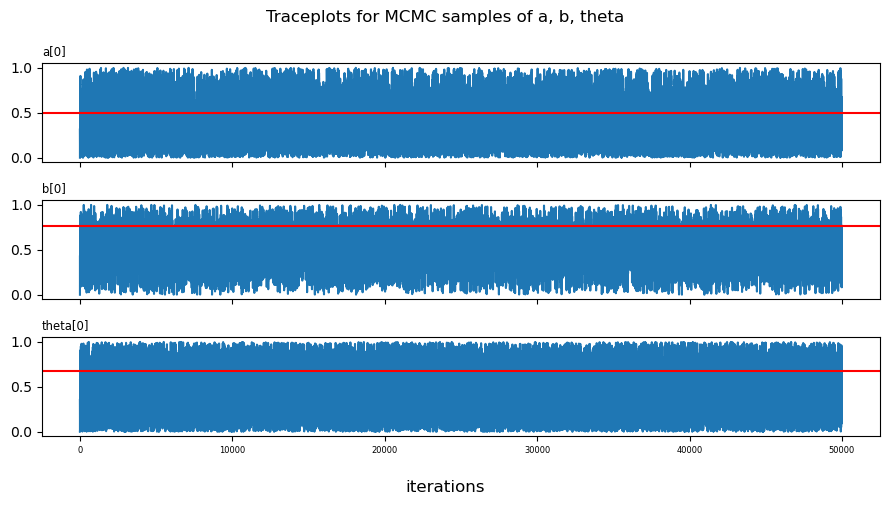

In [17]:
# Traceplots of samples
fig1, (ax1, ax2, ax3) = plt.subplots(nrows=3, figsize=(9,5), sharex=True)
fig1.suptitle('Traceplots for MCMC samples of a, b, theta')

t = range(N)

ax1.plot(t, samples[0][:,0])
ax1.axhline(true_a[0], color="red")
plt.tick_params('x', labelsize=6)
ax1.set_title("a[0]", fontsize='small', loc='left')

ax2.plot(t, samples[1][:,0])
ax2.axhline(true_b[0], color="red")
ax2.set_title("b[0]", fontsize='small', loc='left')

ax3.plot(t, samples[2][:,0])
ax3.axhline(true_theta[0], color="red")
ax3.set_title("theta[0]", fontsize='small', loc='left')

fig1.supxlabel('iterations')
fig1.tight_layout()
plt.show()

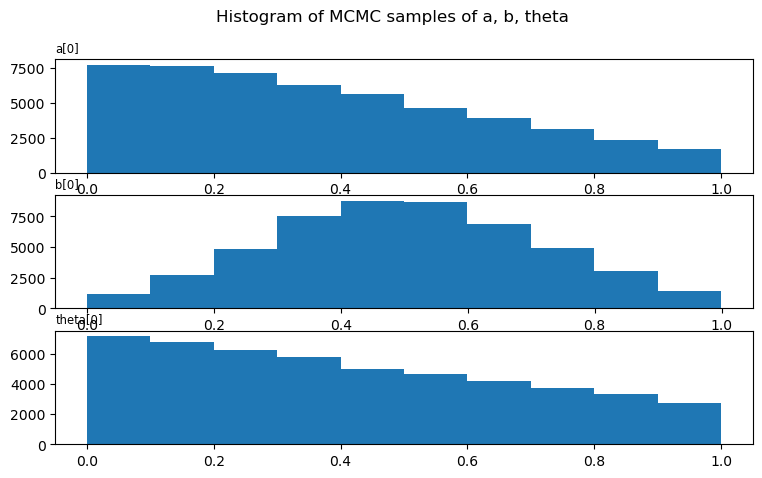

In [19]:
# Histogram of samples
fig2, (ax1, ax2, ax3) = plt.subplots(nrows=3, figsize=(9,5))
fig2.suptitle('Histogram of MCMC samples of a, b, theta')

ax1.hist(samples[0][:,0])
ax1.set_title("a[0]", fontsize='small', loc='left')
ax2.hist(samples[1][:,0])
ax2.set_title("b[0]", fontsize='small', loc='left')
ax3.hist(samples[2][:,0])
ax3.set_title("theta[0]", fontsize='small', loc='left')

plt.show()

#### Adaptive Metropolis-within-Gibbs Results

In [20]:
sigmasq_a, sigmasq_b, sigmasq_t = torch.tensor([1.0]), torch.tensor([1.0]), torch.tensor([1.0])  # priors

samples_ada = gibbs(init_a, init_b, init_t, Y, sigmasq_a, sigmasq_b, sigmasq_t, niter=N, adapt=True)

Starting Gibbs sampler with adaptation... 
--------------------------------------------



100%|██████████| 49999/49999 [1:07:47<00:00, 12.29it/s]

Done sampling.
Average acceptance rates:
 tensor([0.3005, 0.2998, 0.3006, 0.3001, 0.2997, 0.2999, 0.2997, 0.2996, 0.2999,
        0.2996]) 
 tensor([0.3001, 0.3000, 0.3000, 0.2994, 0.3002, 0.2998, 0.3005, 0.3001, 0.3002,
        0.2996]) 
 tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.3000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 

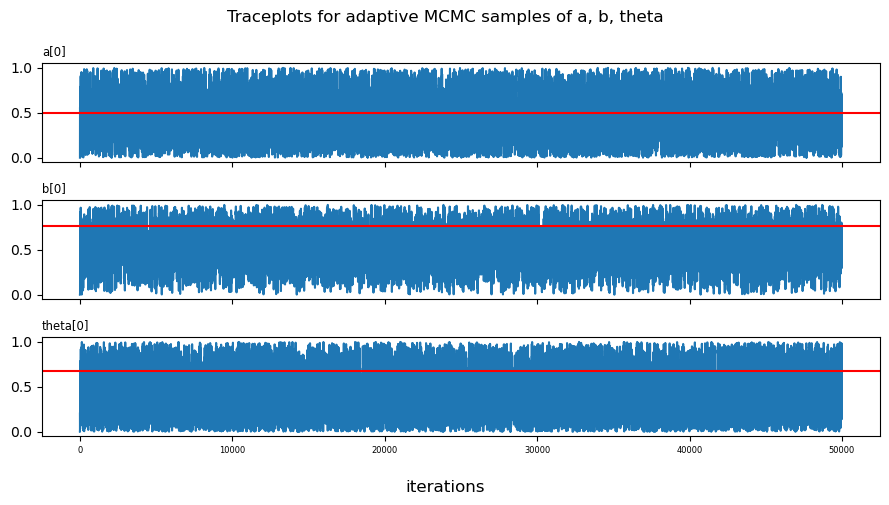

In [21]:
fig3, (ax1, ax2, ax3) = plt.subplots(nrows=3, figsize=(9,5), sharex=True)
fig3.suptitle('Traceplots for adaptive MCMC samples of a, b, theta')

t = range(N)

ax1.plot(t, samples_ada[0][:,0])
ax1.axhline(true_a[0], color="red")
plt.tick_params('x', labelsize=6)
ax1.set_title("a[0]", fontsize='small', loc='left')

ax2.plot(t, samples_ada[1][:,0])
ax2.axhline(true_b[0], color="red")
ax2.set_title("b[0]", fontsize='small', loc='left')

ax3.plot(t, samples_ada[2][:,0])
ax3.axhline(true_theta[0], color="red")
ax3.set_title("theta[0]", fontsize='small', loc='left')

fig3.supxlabel('iterations')
fig3.tight_layout()
plt.show()

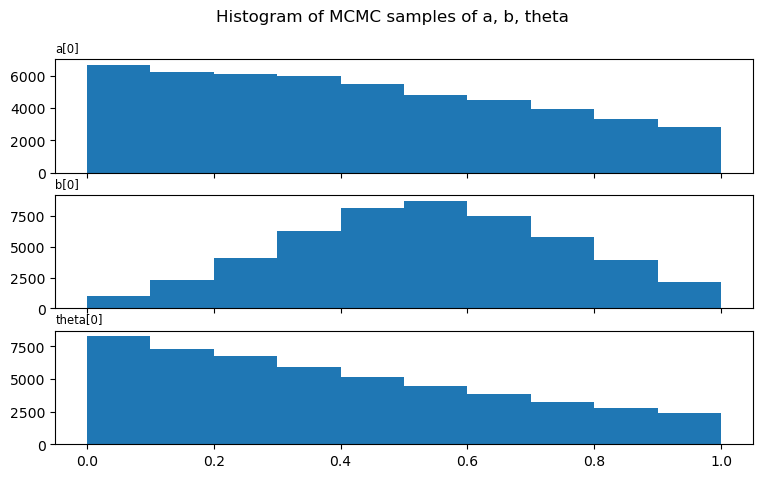

In [22]:
# Histogram of samples
fig4, (ax1, ax2, ax3) = plt.subplots(nrows=3, figsize=(9,5), sharex=True)
fig4.suptitle('Histogram of MCMC samples of a, b, theta')

ax1.hist(samples_ada[0][:,0])
ax1.set_title("a[0]", fontsize='small', loc='left')
ax2.hist(samples_ada[1][:,0])
ax2.set_title("b[0]", fontsize='small', loc='left')
ax3.hist(samples_ada[2][:,0])
ax3.set_title("theta[0]", fontsize='small', loc='left')

plt.show()